# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheetname=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [3]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheetname=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [4]:
# Build data dataframe with customer_name and one column per offer
data = pd.pivot_table(df_transactions, values='n', index=['customer_name'],columns=['offer_id'],fill_value=0)
data.reset_index(level=0, inplace=True)
data.head()

offer_id,customer_name,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,Adams,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,Allen,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,Anderson,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
3,Bailey,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Baker,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

### Answers

Lower values for the Sum of Squares in general will represent better clusterings, although this value can be made equal to 0 by choosing as many clusters as there are points. Therefore, like in the elbow method, we should try to pick the first value, such that after it, increasing the number of clusters does not represent a major gain in reducing the current Sum of Squares.

In [5]:
# Build numpy matrix with 0/1 values from data dataframe
x_cols = data.loc[:,data.columns != 'customer_name'].values
x_cols

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [1, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 1]], dtype=int64)

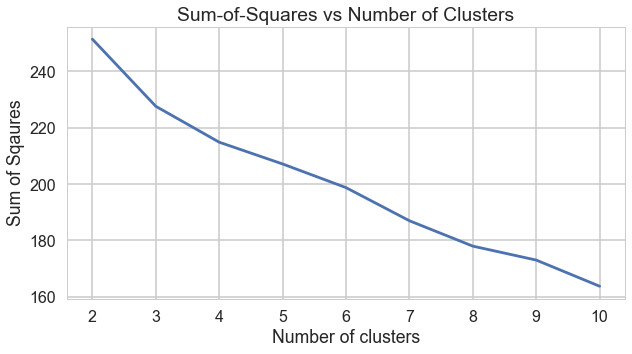

In [6]:
from sklearn.cluster import KMeans

clusters=range(2,11)
# Save KMeans results in list
k_means_vars = [KMeans(n_clusters=k, random_state=0).fit(x_cols) for k in clusters]
# List of Sum of Squares depending on n_clusters
SS = [x.inertia_ for x in k_means_vars]

# plotting SS values versus the number of clusters used 
plt.figure(figsize=(10,5))
plt.plot(clusters,SS)
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Sqaures')
plt.title('Sum-of-Squares vs Number of Clusters')
plt.show()

In [7]:
# Compute the actual drops in SS
np.diff(SS)

array([-23.83531746, -12.74503968,  -7.73019955,  -8.39976566,
       -11.75851783,  -9.01258117,  -4.94972944,  -9.28674242])

It is hard to choose a good value for k, as no elbow can be visualized in the graph. Based on the actual decreases in the SS value I would choose k=7, the last double digit decrease in SS. The difficulty of choosing a good k is in part due to the fact that we have a very high dimensional space. In such spaces the Euclidean distance, used by sklearn KMeans, is not a good tool for determining how far a point is from the center of the cluster. This is because there are several dimensions along which each point will be far from the center to which it is associated, and this will make the Euclidean distance *similar* for all values. That is: the distance of a point from its center will not differ much from the distance of such point from other centers. 

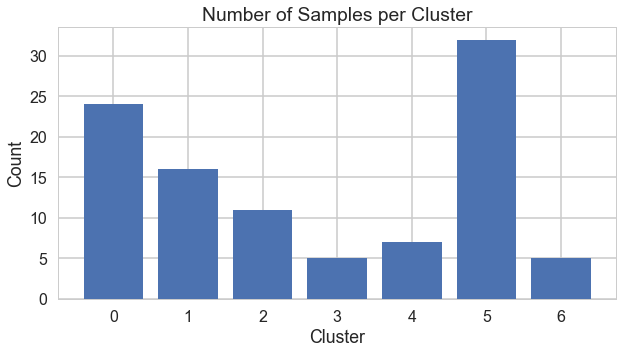

In [8]:
# Notice that n_clusters=7 is the 6th value in our range and therefore corresponds to index 5
xs = list(range(7))
counts = np.bincount(k_means_vars[5].labels_)

# Barplot of number of points per cluster
plt.figure(figsize=(10,5))
plt.bar(xs,counts)
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Number of Samples per Cluster')
plt.show()

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

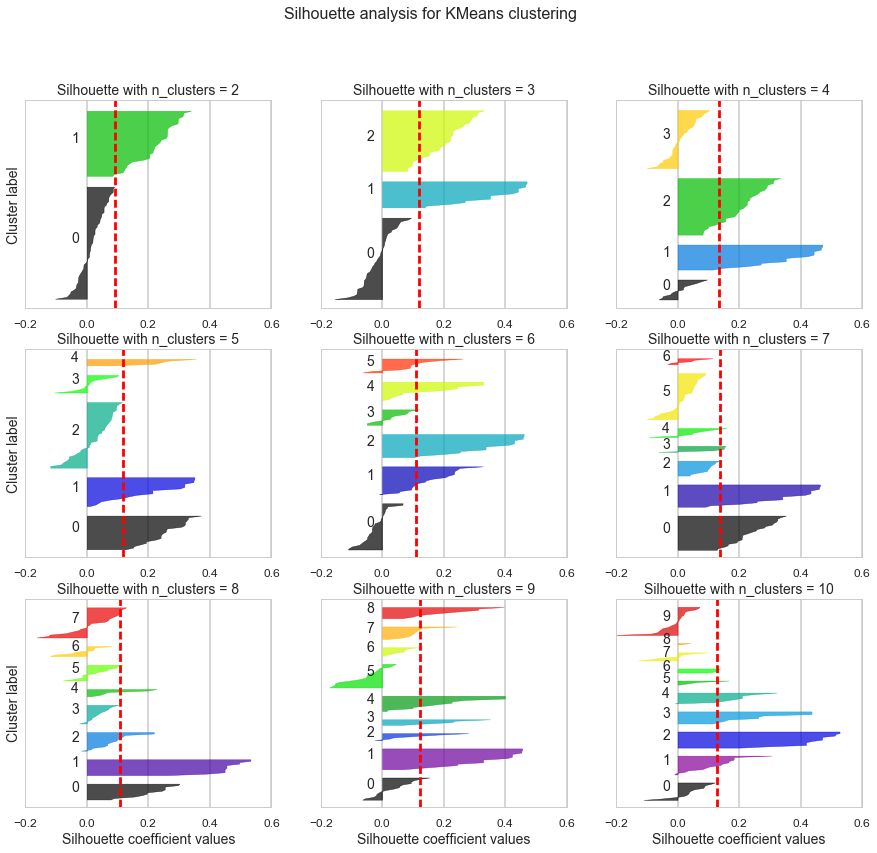

In [9]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

# Create subplot with 3 rows and 3 columns
fig, axes = plt.subplots(3, 3)
fig.set_size_inches(15, 13)

for ax,k in zip(fig.get_axes(), clusters):
    # All values of x are within these limits
    ax.set_xlim([-0.2, .6])
    # The (k+1)*5 inserts blank space between silhouette plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, x_cols.shape[0] + (k + 1) * 5])
    # Recover labels from k_means_vars
    labels = k_means_vars[k-2].labels_

    # Compute silhouette_score average 
    silhouette_avg = silhouette_score(x_cols, labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_cols, labels)

    y_lower = 5
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        ith_cluster_silhouette_values.sort()
        
        # Set y_upper based on cluster size
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # Plot silhouette and color it
        color = cm.spectral(float(i) / k)
        ax.fill_betweenx(np.arange(y_lower, y_upper),0, ith_cluster_silhouette_values, facecolor=color, \
                         edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers in the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i), fontsize=14)

        # Compute the new y_lower for next plot
        y_lower = y_upper + 5 
    
    # Set title for each plot and labels on left and bottom plots
    ax.set_title('Silhouette with n_clusters = {0:d}'.format(k),fontsize=14)
    if k >=8:
        ax.set_xlabel("Silhouette coefficient values",fontsize=14)
    if k in [2,5,8]:
        ax.set_ylabel("Cluster label",fontsize=14)

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.2, 0, 0.2, 0.4, 0.6])
    plt.setp(ax.get_xticklabels(), fontsize=12)
    
plt.suptitle('Silhouette analysis for KMeans clustering', fontsize=16)
plt.show()

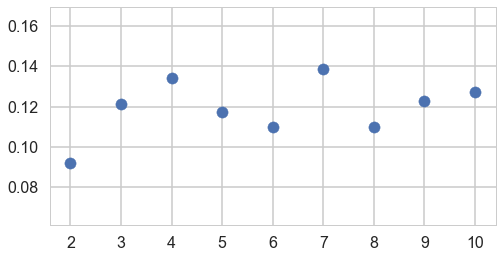

In [10]:
averages = []
for k in clusters:
    # Recover labels from k_means_vars
    labels = k_means_vars[k-2].labels_
    # Compute silhouette_score average 
    averages.append(silhouette_score(x_cols, labels))

plt.figure(figsize=(8,4))
plt.scatter(clusters,averages)
plt.show()

The highest value is for k=7, therefore this suggest to use the same number of clusters as we chose for the elbow method. We must state once again that this choice is not exactly a good one as the actual value of the silhouette score is less than .14, a very low value. Indeed, from the individual silhouette graphs we can see that many values are mislabelled as their individual silhouette score is negative. This seems to suggest that we have either not chosen a value of clusters high enough to find the underlying structure, or more simply that such a structure does not exist in this dataset. We also do not have many data values, as we have only 100 customers, and this makes finding any structure more complicated.

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [11]:
from sklearn.decomposition import PCA

# Create dataframe with customer names
df_pca = pd.DataFrame(data['customer_name'])

# label customers using 7 clusters
df_pca['cluster'] = k_means_vars[5].labels_

# PCA using 2 components
pca = PCA(n_components=2)
df_pca['x'] = pca.fit_transform(x_cols)[:,0]
df_pca['y'] = pca.fit_transform(x_cols)[:,1]
print(pca.explained_variance_ratio_)

[ 0.14386393  0.10800289]


In [12]:
print('Percentage of explained variance using 2 components: {0:.2f}%'.format(100*pca.explained_variance_ratio_.sum()))
df_pca.head(2)

Percentage of explained variance using 2 components: 25.19%


,customer_name,cluster,x,y
0,Adams,0,1.007580,0.108215
1,Allen,5,-0.287539,0.044715


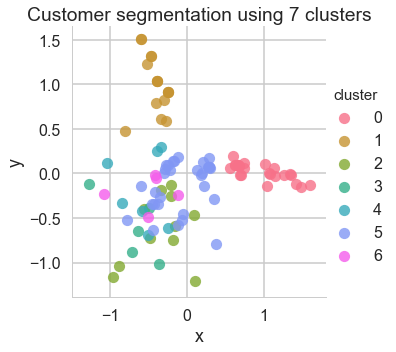

In [13]:
import seaborn as sns

sns.lmplot(x='x', y='y', data=df_pca, hue='cluster', fit_reg=False)
plt.title('Customer segmentation using 7 clusters')
plt.show()

There seem to be three clusters, two corrsponding to the clusters labelled 0 and 1 in the plot above and the other containing all the other customers. The method that went closer to choosing the best k value, seems to be the Elbow Method. We could have argued that the reduction in SS from 2 to 3 was the last great reduction. The silhouette method does not show 3 as the best value.

One major point to consider here is that, using only 2 components, we are able to explain only about 25% of the variation. That is: 2 components are not enough for this dataset, and therefore the visuals produced using only 2 components might not catch entirely the underlying structure of the data. What we are able to clearly identify is two clusters, those labelled 0 and 1, but not much more. Indeed it seems like the rest of the customers has not been split at all. 

We now plot the data using 3 clusters.

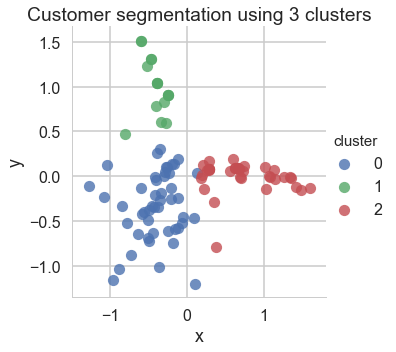

In [14]:
df_pca['cluster'] = k_means_vars[1].labels_
sns.lmplot(x='x', y='y', data=df_pca, hue='cluster', fit_reg=False)
plt.title('Customer segmentation using 3 clusters')
plt.show()

In [15]:
cluster_0 = df_transactions[df_transactions['customer_name'].isin(df_pca.loc[df_pca['cluster'] == 0,:]['customer_name'])]
cluster_0 = cluster_0.merge(df_offers, on='offer_id', how='left')

In [16]:
cluster_1 = df_transactions[df_transactions['customer_name'].isin(df_pca.loc[df_pca['cluster'] == 1,:]['customer_name'])]
cluster_1 = cluster_1.merge(df_offers, on='offer_id', how='left')

In [17]:
cluster_2 = df_transactions[df_transactions['customer_name'].isin(df_pca.loc[df_pca['cluster'] == 2,:]['customer_name'])]
cluster_2 = cluster_2.merge(df_offers, on='offer_id', how='left')

In [18]:
print(cluster_0.varietal.value_counts(),'\n')
print(cluster_1.varietal.value_counts(),'\n')
print(cluster_2.varietal.value_counts(),'\n')

Champagne             74
Cabernet Sauvignon    31
Prosecco              21
Chardonnay            14
Malbec                14
Merlot                13
Espumante              8
Pinot Noir             7
Pinot Grigio           1
Name: varietal, dtype: int64 

Pinot Noir    37
Prosecco       2
Chardonnay     1
Malbec         1
Champagne      1
Merlot         1
Name: varietal, dtype: int64 

Espumante             32
Prosecco              20
Malbec                17
Pinot Grigio          16
Champagne              6
Merlot                 6
Cabernet Sauvignon     1
Name: varietal, dtype: int64 



In [19]:
print(cluster_0['origin'].value_counts(),'\n')
print(cluster_1['origin'].value_counts(),'\n')
print(cluster_2['origin'].value_counts(),'\n')

France          85
Chile           30
Italy           12
New Zealand     11
Oregon          11
California      10
Australia        9
Germany          8
South Africa     7
Name: origin, dtype: int64 

Australia       13
Italy           12
Germany          7
France           7
California       2
New Zealand      1
South Africa     1
Name: origin, dtype: int64 

France          36
Australia       17
South Africa    17
Oregon          15
Chile            7
California       4
New Zealand      1
Germany          1
Name: origin, dtype: int64 



In [20]:
print(cluster_0['min_qty'].value_counts(),'\n')
print(cluster_1['min_qty'].value_counts(),'\n')
print(cluster_2['min_qty'].value_counts(),'\n')

72     117
144     42
6       13
12      11
Name: min_qty, dtype: int64 

144    13
6      12
72     11
12      7
Name: min_qty, dtype: int64 

6      85
72      6
12      4
144     3
Name: min_qty, dtype: int64 



In [21]:
print(cluster_0['discount'].mean(),'\n')
print(cluster_1['discount'].mean(),'\n')
print(cluster_2['discount'].mean(),'\n')

63.459016393442624 

52.116279069767444 

55.285714285714285 



Looking at some of the results above, where we split the customers according to their clusters, we can identify a typical customer in each of the clusters. 
 * cluster_0: buys large amount of wines, at a greater discount, and most likely this wine will be a Champagne from France
 * cluster_1: buys only Pinot Noir, from anywhere and in any size, paying less attention to the discount offered
 * cluster_2: buys in small sizes, just about any varietal, from anywhere, and preferrably at a greater discount

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

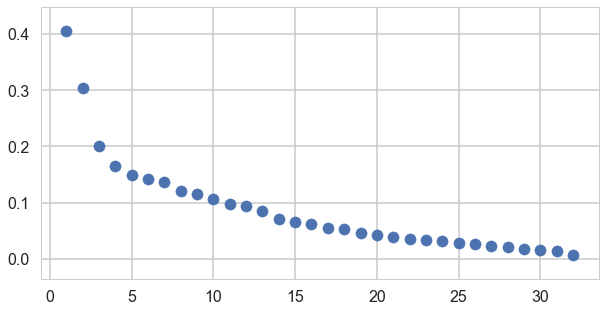

In [22]:
# Initialize a new PCA model with a default number of components.
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(x_cols)

xs = range(1,len(pca.explained_variance_)+1)
plt.figure(figsize=(10,5))
plt.scatter(xs,pca.explained_variance_)
plt.show()

The above plot shows that the elbow point is 4 or 5. The plot, though, also shows that at this number of components the value of the explained variance, compared to the first principal component is still very high. This implies that, even when choosing 5 components, more than half of the variance will be unexplained, as shown below.

In [23]:
print('Unexplained variance with 5 components: {0:.2f}%'.format(100*(1-pca.explained_variance_ratio_[:5].sum())))

Unexplained variance with 5 components: 56.57%


## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [24]:
from sklearn.cluster import AffinityPropagation, SpectralClustering, AgglomerativeClustering, DBSCAN

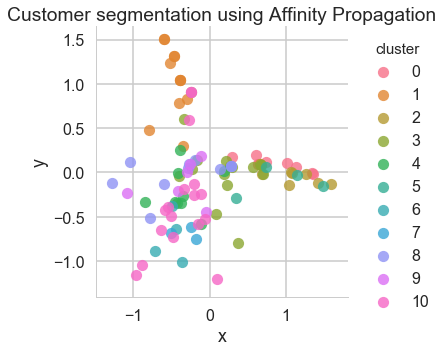

In [25]:
# clustering using Affinity Propagation
APmodel = AffinityPropagation(damping=.8)
APmodel.fit(x_cols)
# Plot of clusters
df_pca['cluster'] = APmodel.labels_
sns.lmplot(x='x', y='y', data=df_pca, hue='cluster', fit_reg=False)
plt.title('Customer segmentation using Affinity Propagation')
plt.show()

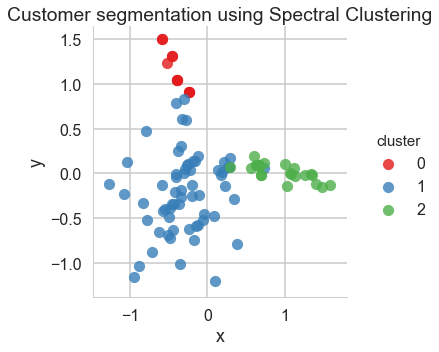

In [26]:
# Clustering using Spectral Clustering
SCmodel = SpectralClustering(n_clusters=3)
SCmodel.fit(x_cols)
# Plot of clusters
df_pca['cluster'] = SCmodel.labels_
sns.lmplot(x='x', y='y', data=df_pca, hue='cluster', fit_reg=False, palette='Set1')
plt.title('Customer segmentation using Spectral Clustering')
plt.show()

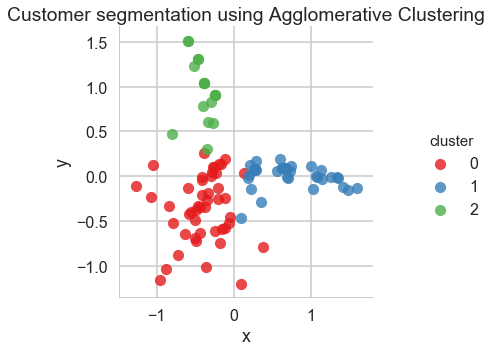

In [27]:
# Clustering using Agglomerative Clustering
ACmodel = AgglomerativeClustering(n_clusters=3)
ACmodel.fit(x_cols)
# Plot of clusters
df_pca['cluster'] = ACmodel.labels_
sns.lmplot(x='x', y='y', data=df_pca, hue='cluster', fit_reg=False, palette='Set1')
plt.title('Customer segmentation using Agglomerative Clustering')
plt.show()

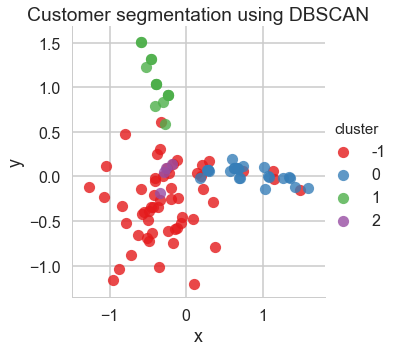

In [28]:
# Clustering using DBSCAN
DBmodel = DBSCAN(eps=1.25, min_samples=4)
DBmodel.fit(x_cols)
# Plot of clusters
df_pca['cluster'] = DBmodel.labels_
sns.lmplot(x='x', y='y', data=df_pca, hue='cluster', fit_reg=False, palette='Set1')
plt.title('Customer segmentation using DBSCAN')
plt.show()

Of the 4 clustering technique the one that seems to be performing better with this dataset is Agglomerative Clustering. Although, the number of clusters needs to be passed to the algorithm, from the visualization it seems like the clusters are better defined than Spectral Clustering, which also needs to know the number of clusters. When passing n_clusters=3, for example, it does a better job at identifying the clusters found with the KMeans method. 

The one that seems to be doing worse is Affinity Propagation, changing the value of the damping parameter does not lead to identifying different sets and numbers of clusters, indeed for values below .8 it will find 14 clusters, and for values above .8 it will find 11 clusters. Finally, DBSCAN performance is mixed, as it seems to identify clusters pretty well but it is very sensitive to the parameters entered, as to the number of clusters and which points belong to them.